<a href="https://colab.research.google.com/github/lucia990/ADM_GROUP-30_HW_4/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Data import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/MyDrive/ADM_HW_4')

In [3]:
!pwd

/content/drive/MyDrive/ADM_HW_4


In [ ]:
!kaggle datasets download -d shivamb/bank-customer-segmentation

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.8/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.8/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!unzip bank-customer-segmentation.zip

Archive:  bank-customer-segmentation.zip
  inflating: bank_transactions.csv   


###Inspect the dataset

In [ ]:
#create the dataframe
import pandas as pd
data = pd.read_csv('bank_transactions.csv', usecols = ['CustomerID', 'CustomerDOB','CustGender',	'CustLocation',	'CustAccountBalance', 'TransactionDate', 'TransactionTime',	'TransactionAmount (INR)'])
#drop the columns containing transaction and customer IDs since they are not useful information for similarity detection 

In [ ]:
#group by the customer id. For each of them we pick the last transaction
customer_data = data.groupby('CustomerID').last()
customer_data.reset_index(drop = True, inplace = True)

In [ ]:
#check how many missing values there are in the dataset
customer_data.isna().sum()

CustomerDOB                2372
CustGender                  803
CustLocation                114
CustAccountBalance         1665
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

In [ ]:
customer_data.dropna(inplace= True)
customer_data.reset_index(drop = True, inplace = True)

In [ ]:
customer_data.isna().sum()

CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

Now we want the data in each column to be of the types we can manipulate better. 


#### Transaction Date

In [ ]:
#we want the date to be of datetime type
customer_data['TransactionDate'] = pd.to_datetime(customer_data.TransactionDate)

In [ ]:
customer_data.TransactionDate

0        2016-09-08
1        2016-08-14
2        2016-07-08
3        2016-09-15
4        2016-08-18
            ...    
879354   2016-07-08
879355   2016-09-15
879356   2016-08-18
879357   2016-08-28
879358   2016-09-25
Name: TransactionDate, Length: 879359, dtype: datetime64[ns]

In [ ]:
customer_data.TransactionDate.dt.year.value_counts()

2016    879359
Name: TransactionDate, dtype: int64

We see that our dataset deals with transactions in 2016. 

#### Date of Birth

In [ ]:
#we want the date to be of datetime type
customer_data['CustomerDOB'] = pd.to_datetime(customer_data.CustomerDOB)

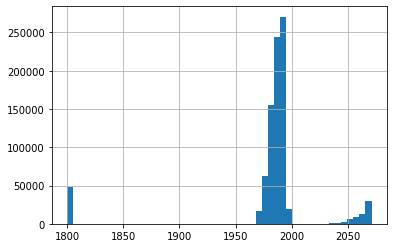

In [ ]:
customer_data.CustomerDOB.dt.year.hist(bins= 50)

In [ ]:
customer_data.loc[customer_data.CustomerDOB.dt.year == 1800, 'CustomerDOB']

16       1800-01-01
28       1800-01-01
49       1800-01-01
78       1800-01-01
85       1800-01-01
            ...    
879309   1800-01-01
879311   1800-01-01
879317   1800-01-01
879325   1800-01-01
879328   1800-01-01
Name: CustomerDOB, Length: 47541, dtype: datetime64[ns]

In [ ]:
customer_data.loc[customer_data.CustomerDOB.dt.year > 2016, 'CustomerDOB'].sort_values()

181206   2018-03-05
210272   2019-12-15
427436   2019-12-15
4230     2019-12-15
177641   2019-12-15
            ...    
872086   2071-12-30
500052   2071-12-30
315875   2071-12-30
464861   2071-12-31
334142   2071-12-31
Name: CustomerDOB, Length: 63124, dtype: datetime64[ns]

We notice something weird: according to this dataset there are customer born in 1800 and after 2016. This is very unlikely: maybe for that customer the date of birth was missing and replaced with a default one. What we can do is dropping the corresponding rows (but we see that in this way we are going to lose more than 130000 transactions) or "fix" the data. Since we have to hash the customer, we want the data to be fixed in a way that does not compromise the results of the hashing operation. 

We notice also that the DOB in 1800 have the same exact date, unlike the successive DOB, so maybe it is better to correct them with different approaches:
- for DOB > 2016 we simply subtract 100 years in order to assign a likely date of birth. Of course this represents an issue for finding similar customers, but better than dropping all the information related to these transactions. 
- for DOB = **1800-01-01** we need to replace the date of birth with the customer resulting the most similar to the customers whos DOB is wrong. 

In [ ]:
customer_data.loc[customer_data.CustomerDOB.dt.year > 2016, 'CustomerDOB'] = customer_data.loc[customer_data.CustomerDOB.dt.year > 2016, 'CustomerDOB'] - pd.DateOffset(years = 100)

In [ ]:
customer_data.loc[customer_data.CustomerDOB.dt.year > 2016, 'CustomerDOB'].count()

0

We fixed the first problem. We want to find a way to fix the second. If we find some common feature for all those transactions with equal DOB we can deduct a solution for dealing with them. 
In this part, we create a subset of the dataframe containing only the transactions with the wrong date of birth and find common features among them. The chosen date of birth chosen for all these transactions will be the DOB of the customer having these common features.  

In [ ]:
#dataframe containing only the data with the wrong date of birth
#This dataframe will help us finding similar behaviors among the customers
sub_data = customer_data.loc[customer_data.CustomerDOB.dt.year == 1800]

For the majority, the wrong date are related to male customers. 

In [ ]:
sub_data.CustAccountBalance.mean()

268667.53402389516

In [ ]:
sub_data.CustLocation.value_counts()


NEW DELHI                             6560
MUMBAI                                3700
BANGALORE                             3044
DELHI                                 2685
GURGAON                               2628
                                      ... 
COLLEGE KEMPAPURA HEBBAL BANGALORE       1
CHINCHWAD PUNE                           1
RAMDEV TEMPLE RANGAREDDY                 1
DARYA GANJ NEW DELHI                     1
NARNAUL                                  1
Name: CustLocation, Length: 1603, dtype: int64

In [ ]:
sub_data['TransactionAmount (INR)'].value_counts()

1000.00    2293
500.00     1755
2000.00     950
200.00      910
100.00      845
           ... 
5446.00       1
9426.00       1
1165.50       1
7209.68       1
9511.36       1
Name: TransactionAmount (INR), Length: 12652, dtype: int64

We look for a male customer, located in New Delhi, with a transaction amount of 1000. 

In [ ]:
#create the dataframe containing the info we need
sub_data1 = customer_data[customer_data['CustAccountBalance'] >= 268667 ][customer_data['CustLocation'] == 'NEW DELHI'][customer_data['TransactionAmount (INR)'] == 1000][customer_data['CustGender'] == 'M']

<ipython-input-33-742b9d1d76d5>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_data1 = customer_data[customer_data['CustAccountBalance'] >= 268667 ][customer_data['CustLocation'] == 'NEW DELHI'][customer_data['TransactionAmount (INR)'] == 1000][customer_data['CustGender'] == 'M']


In [ ]:
#we want to keep only correct data
sub_data1 = sub_data1[sub_data1['CustomerDOB'] != '1800-01-01' ]

In [ ]:
sub_data1.sort_values(by = 'CustAccountBalance')

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
152571,1981-11-09,M,NEW DELHI,271640.32,2016-10-08,81147,1000.0
762459,1989-04-08,M,NEW DELHI,278652.44,2016-02-09,95939,1000.0
455370,1991-02-08,M,NEW DELHI,287095.41,2016-05-09,211627,1000.0
237811,1962-12-17,M,NEW DELHI,288077.41,2016-03-08,72831,1000.0
20736,1962-12-17,M,NEW DELHI,288077.41,2016-10-08,72658,1000.0
...,...,...,...,...,...,...,...
52547,1987-09-24,M,NEW DELHI,5554571.47,2016-08-14,182403,1000.0
758068,1987-09-24,M,NEW DELHI,5554571.47,2016-08-08,191104,1000.0
367354,1987-09-24,M,NEW DELHI,5554571.47,2016-06-08,195010,1000.0
226530,1968-01-13,M,NEW DELHI,6781360.50,2016-08-13,120214,1000.0


The customer that is most similar to the mean of customers whose date of birth is wrong is the first one. We can compare, for instance, the bar plots

We replace the date **1800-01-01** with **1981-11-09**	

In [ ]:
data1 = customer_data.replace(['1800-01-01'], '1981-11-09' )

In [ ]:
data1.reset_index(drop=True, inplace = True)

In [ ]:
data1['CustomerDOB'] = pd.to_datetime(data1['CustomerDOB'])

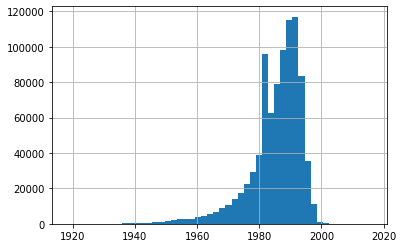

In [ ]:
data1.CustomerDOB.hist(bins = 50)

Now the distribution of birthdays makes sense. As we expected, there is a peak in 1981. However, this shouldn't compromise the hashing procedure. 

#### Transaction Time

In [ ]:
from datetime import datetime

In [ ]:
#Transaction time is not in the format we want
data1['TransactionTime'] = data1.TransactionTime.apply(lambda row: datetime.strptime(str(row).zfill(6), '%H%M%S'))

In [ ]:
data1.TransactionTime.dt.time

0         01:12:29
1         20:44:09
2         22:03:05
3         17:02:54
4         14:11:03
            ...   
879354    00:51:22
879355    12:02:55
879356    12:25:33
879357    21:37:22
879358    22:57:32
Name: TransactionTime, Length: 879359, dtype: object

#### Transaction Date

In [ ]:
data1['TransactionDate'] = pd.to_datetime(data1.TransactionDate)

# 1.Finding Similar Costumers

Companies nowadays are implementing product suggestions to provide users with things they are likely to buy. The process often starts by **finding similar behaviours** among consumers; for this task, we will focus on this part in the specific.
Here you will implement an algorithm to find the most similar match to a consumer given his bank account information. In particular, you will implement your version of the LSH algorithm that takes as input information about a consumer and finds people similar to the one in the study

## 1.1 Set up the data

In [ ]:
#the dataset we are going to use has been already prepared
data1

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,1983-05-08,M,NEW DELHI,120180.54,2016-09-08,1900-01-01 01:12:29,356.0
1,1994-07-28,M,MUMBAI,24204.49,2016-08-14,1900-01-01 20:44:09,1499.0
2,1984-08-19,M,MUMBAI,161848.76,2016-07-08,1900-01-01 22:03:05,250.0
3,1990-05-29,F,CHAMPARAN,496.18,2016-09-15,1900-01-01 17:02:54,30.0
4,1965-06-21,M,KOLKATA,87058.65,2016-08-18,1900-01-01 14:11:03,5000.0
...,...,...,...,...,...,...,...
879354,1990-12-24,M,BHIWANDI,133067.23,2016-07-08,1900-01-01 00:51:22,691.0
879355,1996-09-06,M,BANGALORE,96063.46,2016-09-15,1900-01-01 12:02:55,222.0
879356,1993-10-21,M,GUNTUR,5559.75,2016-08-18,1900-01-01 12:25:33,126.0
879357,1995-04-22,M,CHENNAI,35295.92,2016-08-28,1900-01-01 21:37:22,50.0


In [ ]:
import pickle
with open('clean_df.pkl', 'wb') as f:
  pickle.dump(data1, f)
f.close

<function BufferedWriter.close>

## 1.2 Fingerprint hashing

*1. Implement your minhash function from scratch*

The min-hash function has as input a set of shingles and, as output, the so-called **signature matrix**. We want to create it.The signatures we desire to construct for sets are composed of the results of a
large number of calculations, say several hundred, each of which is a “minhash”
of the characteristic matrix.
Hence, the first thing we need to do is obtaining the characteristic matrix associated to our dataset. 

What we have decided to do, since there is no way of obtaining k-shingles from our dataset, i.e. bank transactions, is dividing the variables in bins in a way that the features are discretized at the end.
\
The characteristic matrix will have a small number of rows and as many columns as the number of customers. In each cell of the matrix there will be a one if the customer feature belongs to the bin corresponding to the row. 


#### STEP 1: Feature discretization

The features we want to discretize are: 
- the balance of the customer
- the period of the year (retrieved from the TransactionDate column)
- the period of the day (retrieved from the TransactionTime column)
- the amount of the transaction
- the age of the customer 


- **Customer balance**

Since what we want is creating a finite set of shingles (we will use unigrams), we need to discretize the features. It's the same principle of what we did in the previous cell: instead of a quantitative feature (that seems to specific for each customer) we need a set of few qualitative features. For doing it, we use a sklearn function: sklearn.preprocessing.KBinsDiscetizer

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer
import pandas as pd

In [ ]:
#balance account
balance = KBinsDiscretizer(n_bins = 4, encode = 'ordinal', strategy = 'quantile')

In [ ]:
balance.fit(data1.CustAccountBalance.to_numpy().reshape(-1,1))

KBinsDiscretizer(encode='ordinal', n_bins=4)

In [ ]:
data1['discrete_balance'] = balance.transform(data1.CustAccountBalance.to_numpy().reshape(-1,1))

In [ ]:
data1.discrete_balance.value_counts()


1.0    219851
3.0    219844
2.0    219836
0.0    219828
Name: discrete_balance, dtype: int64

In [ ]:
print('min_class 0:', data1.loc[data1['discrete_balance'] == 0.0, 'CustAccountBalance'].min())
print('max_class 0:', data1.loc[data1['discrete_balance'] == 0.0, 'CustAccountBalance'].max())
print('min_class 1:', data1.loc[data1['discrete_balance'] == 1.0, 'CustAccountBalance'].min())
print('max_class 1:', data1.loc[data1['discrete_balance'] == 1.0, 'CustAccountBalance'].max())
print('min_class 2:', data1.loc[data1['discrete_balance'] == 2.0, 'CustAccountBalance'].min())
print('max_class 2:', data1.loc[data1['discrete_balance'] == 2.0, 'CustAccountBalance'].max())
print('min_class 3:', data1.loc[data1['discrete_balance'] == 3.0, 'CustAccountBalance'].min())
print('max_class 3:', data1.loc[data1['discrete_balance'] == 3.0, 'CustAccountBalance'].max())


min_class 0: 0.0
max_class 0: 4741.91
min_class 1: 4742.35
max_class 1: 16782.63
min_class 2: 16783.58
max_class 2: 57484.17
min_class 3: 57486.74
max_class 3: 115035495.1


We split the account balances in 4 bins 0, 1, 2 and 3, from the lowest to the greatest balances. 

The function we used is useful but in practice we can't use it for each feature. As a matter of fact, there is no way to give labels to bins. To avoid ambiguity among shingles we use another method. 

- **Period of the Year**

For what concern the transaction date it is not interesting to keep all the info for finding similar customers. Two customers can be related if they do transactions in the same period of the year, so we can consider for example the month of the transaction (e.g. customers buying something during Christmas are considered similar). 
Also for the transaction time the reasoning is similar: we keep only the transaction hour. 


In [ ]:
data1.columns

Index(['CustomerDOB', 'CustGender', 'CustLocation', 'CustAccountBalance',
       'TransactionDate', 'TransactionTime', 'TransactionAmount (INR)',
       'discrete_balance'],
      dtype='object')

In [ ]:
#period of the year
labels = ['Jan-Mar', 'Apr-Jun', 'Jul-Sept', 'Oct-Dec']
data1['period_year'] = pd.cut(data1['TransactionDate'].dt.month,  4, labels = labels)

In [ ]:
data1.period_year.value_counts()

Jul-Sept    537647
Oct-Dec     122379
Apr-Jun     111939
Jan-Mar     107394
Name: period_year, dtype: int64

In [ ]:
data1.loc[data1['period_year']=='Oct-Dec', 'TransactionDate' ].dt.month.value_counts()

10    44195
11    41258
12    36926
Name: TransactionDate, dtype: int64

- **Period of the day**

For reducing the number of the shingles without losing any important information (and for avoiding ambiguous shingles) we can use as shingles the period of the day.
For example, we replace the range of hours from 6 to 13 simply in morning (two customers are considered similar if they prefer to do trasaction during the morning. It is not important if one did it at 11 and the other at 12!). 

In [ ]:
#period of the day
labels = ['Night','Morning', 'Afternoon', 'Late evening']
data1['period_day'] = pd.cut(data1['TransactionTime'].dt.hour, 4, labels = labels)

In [ ]:
data1.loc[data1['period_day']=='Night', 'TransactionTime' ].dt.hour.value_counts()

0    15240
1     7453
2     4647
5     4398
3     3883
4     3706
Name: TransactionTime, dtype: int64

In [ ]:
data1.period_day.value_counts()

Late evening    366148
Afternoon       327389
Morning         146495
Night            39327
Name: period_day, dtype: int64

- **Amount of the transaction**

In [ ]:
data1['TransactionAmount (INR)'].describe()

count    8.793590e+05
mean     1.564485e+03
std      6.637781e+03
min      0.000000e+00
25%      1.600000e+02
50%      4.560000e+02
75%      1.200000e+03
max      1.560035e+06
Name: TransactionAmount (INR), dtype: float64

In [ ]:
#amount of the transaction
labels = ['Small','Medium', 'Big']
data1['transaction_size'] = pd.qcut(data1['TransactionAmount (INR)'], q =3, labels = labels)

In [ ]:
data1.transaction_size.value_counts()

Small     294800
Big       292901
Medium    291658
Name: transaction_size, dtype: int64

In [ ]:
#Medium transactions
data1.loc[data1['transaction_size']=='Medium', 'TransactionAmount (INR)' ].describe()

count    291658.000000
mean        471.446172
std         172.043970
min         230.020000
25%         309.000000
50%         459.500000
75%         600.000000
max         860.000000
Name: TransactionAmount (INR), dtype: float64

In [ ]:
#Small transactions
data1.loc[data1['transaction_size']=='Small', 'TransactionAmount (INR)' ].describe()

count    294800.000000
mean        103.874653
std          67.527207
min           0.000000
25%          50.000000
50%         100.000000
75%         164.000000
max         230.000000
Name: TransactionAmount (INR), dtype: float64

In [ ]:
#Big transactions
data1.loc[data1['transaction_size']=='Big', 'TransactionAmount (INR)' ].describe()

count    2.929010e+05
mean     4.122966e+03
std      1.106176e+04
min      8.600100e+02
25%      1.200000e+03
50%      1.890000e+03
75%      3.400000e+03
max      1.560035e+06
Name: TransactionAmount (INR), dtype: float64

- **Customer Age**

For what concerns the date of birth, it is not very useful to keep the whole date, but maybe the age of the customer is more useful. 

In [ ]:
data1['cust_age'] = 2016 - data1.CustomerDOB.dt.year 

In [ ]:
data1.cust_age.value_counts()

35    70658
26    61325
25    60122
27    58292
24    56254
      ...  
0         2
96        2
98        1
91        1
5         1
Name: cust_age, Length: 99, dtype: int64

In [ ]:
#we divide the customer age in groups 
def age_group(age):
  if age in range(0, 12):
    age_group = 'child'
  elif age in range(13, 25):
    age_group = 'teen-ager'
  elif age in range(25, 50):
    age_group = 'adult'
  else:
    age_group = 'old'
  return age_group

In [ ]:
data1['age_group'] = data1.cust_age.apply(lambda x: age_group(x))

In [ ]:
data1.age_group.value_counts()

adult        673818
teen-ager    168332
old           37009
child           200
Name: age_group, dtype: int64

Now, for each column, the values are categorical. Keep only discrete 

In [ ]:
with open('custom_df.pkl', 'wb') as f: 
  pickle.dump(data1, f)
f.close

<function BufferedWriter.close>

In [ ]:
import pickle
with open('custom_df.pkl', 'rb') as f:
  data1 = pickle.load(f)
f.close

<function BufferedReader.close>

In [ ]:
# Keep only discrete features
discr_df = data1[['CustGender', 'CustLocation', 'discrete_balance', 'period_year', 'period_day', 'transaction_size', 'age_group' ]]

In [ ]:
#create a pickle file containing the modified dataset
import pickle
with open('modified_df.pkl', 'wb') as f:
    pickle.dump(discr_df, f)
f.close

<function BufferedWriter.close>

In [4]:
import pickle
with open('modified_df.pkl', 'rb') as f:
  modified_df = pickle.load(f)
f.close

<function BufferedReader.close>

In [ ]:
modified_df

,CustGender,CustLocation,discrete_balance,period_year,period_day,transaction_size,age_group
0,M,NEW DELHI,3.0,Jul-Sept,Night,Medium,adult
1,M,MUMBAI,2.0,Jul-Sept,Late evening,Big,teen-ager
2,M,MUMBAI,3.0,Jul-Sept,Late evening,Medium,adult
3,F,CHAMPARAN,0.0,Jul-Sept,Afternoon,Small,adult
4,M,KOLKATA,3.0,Jul-Sept,Afternoon,Big,old
...,...,...,...,...,...,...,...
879354,M,BHIWANDI,3.0,Jul-Sept,Night,Medium,adult
879355,M,BANGALORE,3.0,Jul-Sept,Afternoon,Small,teen-ager
879356,M,GUNTUR,1.0,Jul-Sept,Afternoon,Small,teen-ager
879357,M,CHENNAI,2.0,Jul-Sept,Late evening,Small,teen-ager


We have 879359 rows. Through them we have to retrieve the "shingles", i.e. the unique values a customer can have.

#### STEP 2: Find unique values

In [9]:
all_unique_values = []
for column in modified_df:
  values = modified_df[column].unique().tolist()
  set_values = set(values)
  unique_values = list(set_values)
  all_unique_values.append(unique_values)
print(all_unique_values)

[['F', 'T', 'M'], ['BHAYANDER', 'PHOENIX HOSPITAL MUMBAI', 'DENAP', 'COLO MUMBAI', 'THANJAVUR DIST', 'ESTATE DAHISAR E MUMBAI', 'OJHAR MIG', 'DUMUDUMA', 'HERO HONDA SHOW ROOM HOSUR', 'BARDHAMAN AT GORAI MANSION ASANSOL', 'BARDOLI', 'MANAULI', 'RANGPO', 'WARDHA', 'TANDULWADI', 'AUNDH CAMP PUNE', 'HUTHUKUR ROAD NELLORE', 'JANGIPUR', 'KHATAULI', 'DAVANGERE (DT)', 'MANGALAGIRI', 'MOHAMADPUR', 'TARAPUR APP BOISAR', 'VISHAKAPATNAM', 'VIRAR (EAST) THANE', 'ITANGAR', 'PETROL PUMP AURANGABAD', 'EAST MUMBAI', 'MURADNAGAR', 'CHAKALA ANDHERI -E MUMBAI', 'HOTEL HYDERABAD', 'MASJID MIRA ROAD E DIST THANE', 'KATARGAM  SURAT', 'BUNK KANCHIPURAM DT', 'GHODBUNDER ROAD THANE (W) THANE', 'W MUMBAI', 'CHAK DANAPUR CANTT PATNA', 'RD GOREGAON EAST', 'MAU', 'GANESH TEMPLE PUNE', 'NO-9 BLOCK-A MAHIPALPUR NEW DELHI', 'PATTIVEERANPATTI', 'DOMBIVALI EAST', 'MUMBAI BHANDUP COMPLEX MUMBAI', 'KURLA WEST - MUMBAI', 'CHITRAKOOT MARG JAIPUR', 'N H ENGLISH SCHOO MIRA ROAD MUMBAI', 'DIST NAVSARI', 'PNEW DELHI', 'REIS MAG

In [10]:
unique_data = [x[i] for x in all_unique_values for i in range(len(x))]

In [11]:
print('the number of unique unigrams is: ', len(unique_data))

the number of unique unigrams is:  9000


In [12]:
#we want the shingles not to be ordered
import random
random.shuffle(unique_data)

In [ ]:
with open('shingles.pkl', 'wb') as f:
    pickle.dump(unique_data, f)
f.close

<function BufferedWriter.close>

#### STEP 3: Build the Characteristic matrix

In [13]:
import pickle
import numpy as np
import pandas as pd

In [14]:
#open the pickle file
with open('modified_df.pkl', 'rb') as f:
    modified_df = pickle.load(f)
f.close

<function BufferedReader.close>

In [15]:
#create characteristic matrix
#we use the panda function pd.get_dummies, which convert categorical variable into dummy/indicator variables
#for each categorical variable we create a row of the characteristic matrix 
gender = pd.get_dummies(modified_df['CustGender'])
balance = pd.get_dummies(modified_df['discrete_balance'])
months = pd.get_dummies(modified_df['period_year'])
days = pd.get_dummies(modified_df['period_day'])
size = pd.get_dummies(modified_df['transaction_size'])
age = pd.get_dummies(modified_df['age_group'])


In [16]:
char_matrix1 = np.concatenate([gender, balance, months, days, size, age], axis = 1) #horizontal_concat

In [17]:
char_matrix1

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0]], dtype=uint8)

I tried to add the cities as shingles but, for RAM problems I couldn't handle them. I realize it is a problem for finding similar customer but I was not able to figure out how to solve the issue. 

In [18]:
char_m = np.transpose(char_matrix1)

In [19]:
char_m.shape

(22, 879359)

Now that we have the characteristic matrix we can create the signature matrix. 

#### STEP 4: Create the Signature Matrix

Instead of picking n random permutations of rows, we pick n randomly
chosen hash functions $\ h_1, h_2, . . . , h_n$ on the rows. We construct the signature
matrix by considering each row in their given order. 

In [20]:
import random 

In [21]:
#define a function to generate n hash function (for simulating the effect of th epermutations of the row of the characteristic matrix)
def n_hash(row, n, p):  #p is the size of the hash table. Its value is the first prime number after the last shingle
  hash_list = []
  for _ in range(n):
    h = random.randint(1, n)*(row) % p
    hash_list.append(h)
  return hash_list

Now that we choose the hash functions we can construct the signature matrix. It will have as many rows as the number of hash functions. 

In [22]:
from tqdm import tqdm

In [23]:
import numpy as np

In [24]:
#pre-allocate memory for the signature matrix
signatures = np.matrix(np.ones((22, char_m.shape[1]))* np.inf)
#the signature matrix has a shape (22, 879359) and every element is infinity

In [25]:
signatures

matrix([[inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
        ...,
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf],
        [inf, inf, inf, ..., inf, inf, inf]])

In [26]:
#scan over the row of the caracteristic matrix
for row in tqdm(range(char_m .shape[0])):
  
  hash_list = n_hash(row, 750, 757)  #we choose 750 hash functions #757 is the first prime number after 500
 

  #slide over the columns of the characteristic matrix
  for col in range(char_m.shape[1]): 
    if char_m[row, col] == 1:
      #print(char_matrix[row, col])
      #scan over the rows of the signature matrix
      for i in range(signatures.shape[0]): 
        signatures[i, col] = min(hash_list[i],signatures[i, col])


100%|██████████| 22/22 [03:29<00:00,  9.54s/it]


In [28]:
signatures

matrix([[ 46.,  81.,  51., ...,  81.,  81.,  51.],
        [ 32.,  32.,  32., ...,  32.,  32.,  32.],
        [ 19.,  70.,  19., ...,  70.,  70.,  19.],
        ...,
        [ 36.,  36.,  36., ...,  36.,  36.,  36.],
        [207.,  79.,  79., ..., 503.,  79.,  79.],
        [ 24.,  63.,  24., ..., 303.,  63.,  37.]])

#### STEP 5: Map each consumer to its bin


- One general approach to LSH is to “hash” items several times, in such a way that **similar items are more likely to be hashed to the same bucket than dissimilar
items are**. 


- We then consider any pair that hashed to the same bucket for any
of the hashings to be a *candidate pair*. We check only the candidate pairs for
similarity. The hope is that most of the dissimilar pairs will never hash to the
same bucket, and therefore will never be checked. 


- If we have minhash signatures for the items, an effective way to choose the
hashings is to divide the signature matrix into **b bands consisting of r rows**
each.

Regardless of what those columns look like in the other three bands, this pair
of columns will be a candidate pair. 

In [29]:
signatures.shape

(22, 879359)

- **Threshold choice**
\
Choose a threshold t that defines how similar documents have to be in
order for them to be regarded as a desired *“similar pair”*. 
 Pick a number
of bands b and a number of rows r such that:
\
$\ b*r = n$
\
 and the threshold
t is approximately 
\
$ t = \frac{1}{b}^ \frac{1}{r}$



We have 17 rows. The combination of r and b we can try are:
- b = 22, r = 1;
- b = 1, r = 22;
- b = 2, r = 11; 
 

In [30]:
#b = 15, r = 1
print('t__22 =', 1/22)      #Very bad threshold
print('t_1 =', 1**(1/22))   #Ideal one. 
print('t_2 =', (1/2)**(1/11))

t__22 = 0.045454545454545456
t_1 = 1.0
t_2 = 0.9389309106617063


Since we preprocessed the dataset in order to have dicrete bins of values, we want customers in the same bucket to have the **exact** same values for them. Only in this way we can be sure, once we go back to the original dataframe, to have the most similar customers. 

Now we have to think. The choice of discretize the dataset as we did so far was a bit risky. Moreover, by setting a threshold that allows only identical signatures to be in the same bucket (not unlikely at all, since a subset of bins can be related to more than one customer for its low specifity) we have to be sure that the number of buckets is adequate. The only thing we can do at this point is set the dimension of the hash table in order to reduce the number of false positives. 
Since the number of customers is more than 879000 we can assume that at least 40 customers should go into the same bucket.

In [ ]:
!pwd

/content/drive/MyDrive/ADM_HW_4


In [31]:
from tqdm import tqdm 
import random
import math

In [34]:
#scan over the column of the signature matrix
buckets = {}
b = 720 #equal elements we expect to be in the same buckets (720 = 6!)
n = math.floor(signatures.shape[1]/b)    
for col in tqdm(range(signatures.shape[1])):
  bucket = 0
  #for j in range(3):  #b = 1
  for i in range(22):   # r = 17
    bucket += signatures[i,col]*random.randint(1, n-1)  #hash function we apply to each column of the signature matrix
  bucket = bucket %n
  if bucket not in buckets.keys():
    buckets[bucket] = [col]   
  else: 
    buckets[bucket].append(col)


100%|██████████| 879359/879359 [00:49<00:00, 17820.09it/s]


In [35]:
len(buckets.keys())

1221

In [36]:
len(buckets[list(buckets.keys())[2]])

498

In [37]:
bucket_test = buckets[list(buckets.keys())[0]]

In [38]:
modified_df.filter(bucket_test, axis = 0)

,CustGender,CustLocation,discrete_balance,period_year,period_day,transaction_size,age_group
0,M,NEW DELHI,3.0,Jul-Sept,Night,Medium,adult
39,M,SURAT,0.0,Jul-Sept,Late evening,Small,adult
322,M,PUNE,3.0,Jul-Sept,Late evening,Medium,adult
8221,M,DHARUHERA,2.0,Jan-Mar,Late evening,Medium,adult
12047,M,KAITHAL,0.0,Jul-Sept,Late evening,Small,adult
...,...,...,...,...,...,...,...
870740,M,HYDERABAD,1.0,Apr-Jun,Morning,Small,adult
870973,M,PANCHKULA,2.0,Oct-Dec,Late evening,Big,adult
877128,M,GAUTAM BUDDHA NAGAR,0.0,Apr-Jun,Morning,Small,teen-ager
877539,M,BANGALORE,1.0,Jul-Sept,Late evening,Small,adult


In [39]:
with open('modified_df.pkl', 'rb') as f:
  df = pickle.load(f)
f.close

<function BufferedReader.close>

##1.3 Locality Sensitive Hashing

Now we have, given some users, find the most similar ones. 

In [67]:
#read the query csv
query_df =pd.read_csv('query_users.csv')

In [64]:
query_df.head(15)

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,27/7/78,M,DELHI,94695.61,2/9/16,140310,65.0
1,6/11/92,M,PANCHKULA,7584.09,2/9/16,120214,6025.0
2,14/8/91,M,PATNA,7180.60,10/8/16,221732,541.5
3,3/1/87,M,CHENNAI,56847.75,29/8/16,144138,1000.0
4,4/1/95,M,GURGAON,84950.13,25/9/16,233309,80.0
5,10/1/81,M,WORLD TRADE CENTRE BANGALORE,23143.95,11/9/16,192906,303.0
6,20/9/76,F,CHITTOOR,15397.80,28/8/16,92633,20.0
7,10/4/91,M,MOHALI,426.30,2/8/16,203754,50.0
8,19/3/90,M,MOHALI,4609.34,26/8/16,184015,300.0
9,19/12/70,M,SERAMPORE,6695988.46,27/8/16,144030,299.0


First thing we need to do is preprocessing query customers so that the data is consistent and similar customers can be found. 
The features we want to discretize are: 
- the balance of the customer
- the period of the year (retrieved from the TransactionDate column)
- the period of the day (retrieved from the TransactionTime column)
- the amount of the transaction
- the age of the customer 


In [41]:
from sklearn.preprocessing import KBinsDiscretizer
import pandas as pd
from datetime import datetime

In [42]:
#we divide the customer age in groups 
def age_group(age):
  if age in range(0, 12):
    age_group = 'child'
  elif age in range(13, 25):
    age_group = 'teen-ager'
  elif age in range(25, 50):
    age_group = 'adult'
  else:
    age_group = 'old'
  return age_group

In [65]:
query_df['TransactionTime'] = query_df.TransactionTime.apply(lambda row: datetime.strptime(str(row).zfill(6), '%H%M%S'))

In [68]:
#preprocessing function 
def query_preprocessing(df): 

  #account balance
  balance = KBinsDiscretizer(n_bins = 4, encode = 'ordinal', strategy = 'quantile')
  balance.fit(df.CustAccountBalance.to_numpy().reshape(-1,1))
  df['discrete_balance'] = balance.transform(df.CustAccountBalance.to_numpy().reshape(-1,1))
  
  #period of the year
  labels_month = ['Jan-Mar', 'Apr-Jun', 'Jul-Sept', 'Oct-Dec']
  df['TransactionDate'] = pd.to_datetime(df.TransactionDate)
  df['period_year'] = pd.cut(df['TransactionDate'].dt.month,  4, labels = labels_month)
  
  #period of the day
  df['TransactionTime'] = df.TransactionTime.apply(lambda row: datetime.strptime(str(row).zfill(6), '%H%M%S'))
  labels_day = ['Night','Morning', 'Afternoon', 'Late evening']
  df['period_day'] = pd.cut(df['TransactionTime'].dt.hour, 4, labels = labels_day)

  #amount of the transaction
  labels_size = ['Small','Medium', 'Big']
  df['transaction_size'] = pd.qcut(df['TransactionAmount (INR)'], q =3, labels = labels_size)

  #customer age
  df['CustomerDOB'] = pd.to_datetime(df.CustomerDOB)
  df['cust_age'] = 2016 - df.CustomerDOB.dt.year
  df['age_group'] = df.cust_age.apply(lambda x: age_group(x))

  #return only discrete features
  df = df[['CustGender', 'CustLocation', 'discrete_balance', 'period_year',
       'period_day', 'transaction_size', 'age_group']]

  return df

In [69]:
new_df = query_preprocessing(query_df)

In [136]:
new_df.head(25)

,CustGender,CustLocation,discrete_balance,period_year,period_day,transaction_size,age_group
0,M,DELHI,2.0,Jan-Mar,Afternoon,Small,adult
1,M,PANCHKULA,0.0,Jan-Mar,Morning,Big,teen-ager
2,M,PATNA,0.0,Oct-Dec,Late evening,Medium,adult
3,M,CHENNAI,2.0,Jul-Sept,Afternoon,Medium,adult
4,M,GURGAON,2.0,Jul-Sept,Late evening,Small,teen-ager
5,M,WORLD TRADE CENTRE BANGALORE,1.0,Oct-Dec,Late evening,Medium,adult
6,F,CHITTOOR,1.0,Jul-Sept,Morning,Small,adult
7,M,MOHALI,0.0,Jan-Mar,Late evening,Small,adult
8,M,MOHALI,0.0,Jul-Sept,Late evening,Medium,adult
9,M,SERAMPORE,3.0,Jul-Sept,Afternoon,Medium,old


Now that we preprocessed the query we can proceed with the LSH algorithm. 
We start from the signature matrix of the query customers. We use the same algorithm we used for the previous banking accounts.

In [71]:
#create characteristic matrix
#we use the panda function pd.get_dummies, which convert categorical variable into dummy/indicator variables
#for each categorical variable we create a row of the characteristic matrix 
gender = pd.get_dummies(new_df['CustGender'])
balance = pd.get_dummies(new_df['discrete_balance'])
months = pd.get_dummies(new_df['period_year'])
days = pd.get_dummies(new_df['period_day'])
size = pd.get_dummies(new_df['transaction_size'])
age = pd.get_dummies(new_df['age_group'])


In [72]:
char_matrix = np.concatenate([gender, balance, months, days, size, age], axis = 1) #horizontal_concat

In [75]:
char_m2 = np.transpose(char_matrix)

In [76]:
#define a function to generate n hash function (for simulating the effect of th epermutations of the row of the characteristic matrix)
def n_hash(row, n, p):  #p is the size of the hash table. Its value is the first prime number after the last shingle
  hash_list = []
  for _ in range(n):
    h = random.randint(1, n)*(row) % p
    hash_list.append(h)
  return hash_list

In [77]:
from tqdm import tqdm

In [78]:
#pre-allocate memory for the signature matrix
qsignatures = np.matrix(np.ones((22, char_m2.shape[1]))* np.inf)
#the signature matrix has a shape (17, 879359) and every element is infinity

In [79]:
qsignatures.shape

(22, 50)

In [80]:
#scan over the row of the caracteristic matrix
for row in tqdm(range(char_m2.shape[0])):
  
  hash_list = n_hash(row, 750, 757)  #we choose 500 hash functions #503 is the first prime number after 500
 

  #slide over the columns of the characteristic matrix
  for col in range(char_m2.shape[1]): 
    if char_m2[row, col] == 1:
      #print(char_matrix[row, col])
      #scan over the rows of the signature matrix
      for i in range(qsignatures.shape[0]): 
        qsignatures[i, col] = min(hash_list[i], qsignatures[i, col])


100%|██████████| 20/20 [00:00<00:00, 581.67it/s]


In [81]:
qsignatures

matrix([[ 61.,  61.,  45., ..., 144.,   0., 148.],
        [ 53.,  81.,  53., ...,  53.,   0.,  53.],
        [189.,  76.,  76., ..., 189.,   0., 189.],
        ...,
        [167., 167., 167., ..., 167.,   0., 167.],
        [355., 136., 156., ...,   9.,   0., 136.],
        [217., 123.,  78., ..., 134.,   0., 217.]])

Now, for each row of the new dataframe (i.e., each column of the signature matrix), we have to compute the similarity of the elements hashed in the same bucket. 

In [91]:
def jaccard(doc_1, doc_2):
  num = len(doc_1 & doc_2)
  den = len(doc_1 | doc_2)
  jacc = num / den
  return jacc

#### Test with the first query 

In [87]:
new_df.columns

Index(['CustGender', 'CustLocation', 'discrete_balance', 'period_year',
       'period_day', 'transaction_size', 'age_group'],
      dtype='object')

In [82]:
new_df.head(1)

,CustGender,CustLocation,discrete_balance,period_year,period_day,transaction_size,age_group
0,M,DELHI,2.0,Jan-Mar,Afternoon,Small,adult


In [139]:
#try with only one query customer 
cust_signature = qsignatures[:, 0].tolist()
cust = cust = np.unique(cust_signature)

bucket = 0
for i in range(17):   # r = 17
  bucket += cust[i]*random.randint(1, n-1)  #hash function we apply to each column of the signature matrix
bucket = bucket %n
#put the customer in the corresponding bucket
buckets[bucket].append(0)

In [140]:
no_city = ['CustGender','discrete_balance', 'period_year',
       'period_day', 'transaction_size', 'age_group']
query_cust = set(new_df.loc[0, :].unique())
q_nocity = set(new_df.loc[0, no_city].unique())

In [141]:
#list of customers in the same bucket
near_cust = buckets[bucket]

In [149]:
near_customers = modified_df.filter(near_cust[:-1], axis = 0)

for customer, idx in zip(near_customers.values, near_customers.index):
  sim1 = jaccard(query_cust, set(customer))   #similarity taking into account the city 
  cust_nocity = np.delete(customer, 1)
  sim2 = jaccard(q_nocity, set(cust_nocity))      #similarity without taking into account the city
  near_customers.loc[idx, 'similarity'] = sim1
  near_customers.loc[idx, 'similarity without city'] = sim2


In [137]:
near_customers.sort_values(by = 'similarity', ascending = False).head(10)

,CustGender,CustLocation,discrete_balance,period_year,period_day,transaction_size,age_group,similarity,similarity without city
3781,F,LUDHIANA,0.0,Apr-Jun,Late evening,Medium,adult,0.75,1.000000
21008,F,HYDERABAD,0.0,Apr-Jun,Late evening,Medium,adult,0.75,1.000000
4404,F,BANGALORE,0.0,Apr-Jun,Late evening,Medium,adult,0.75,1.000000
19947,F,KARIMNAGAR,0.0,Apr-Jun,Late evening,Medium,adult,0.75,1.000000
15151,F,MUMBAI,0.0,Jul-Sept,Late evening,Medium,adult,0.75,0.714286
16854,F,MUMBAI,0.0,Apr-Jun,Afternoon,Medium,adult,0.75,0.714286
18442,F,GANGTOK,0.0,Apr-Jun,Late evening,Medium,adult,0.75,1.000000
22065,F,HOSHIARPUR,0.0,Apr-Jun,Late evening,Medium,adult,0.75,1.000000
24058,F,MUMBAI,0.0,Apr-Jun,Late evening,Big,adult,0.75,0.714286
10635,F,MUMBAI,0.0,Jul-Sept,Late evening,Medium,adult,0.75,0.714286


In [145]:
len(near_customers.index)

513

#### Do it with the remaining customers

In [115]:
from tqdm import tqdm 

In [188]:
%%time
for user in range(6):   #scan over the signature matrix of the query
  #try with only one query customer 
  cust_signature = qsignatures[:, user].tolist()
  cust = np.unique(cust_signature)
  bucket = 0
  for i in range(len(cust)):   
    bucket += cust[i]*random.randint(1, n-1)  #hash function we apply to each column of the signature matrix
  bucket = bucket % n
  #put the customer in the corresponding bucket
  
  #near customers are in the same bucket
  near_cust = buckets[bucket]
  near_customers = modified_df.filter(near_cust, axis = 0)   #take from the modified dataframe the rows corresponding to the documents in the bucket
   

  #compute the similarity between the query customer and the other customers in the bucket 
  query_cust = set(new_df.loc[user, :].unique())
  q_nocity = set(new_df.loc[user, no_city].unique())
  #add in the dataframe a colum with the computed similarity
  for customer, idx in zip(near_customers.values, near_customers.index):
    sim1 = jaccard(query_cust, set(customer))   #similarity taking into account the city 
    cust_nocity = np.delete(customer, 1)
    sim2 = jaccard(q_nocity, set(cust_nocity))      #similarity without taking into account the city
    #print(idx)
    near_customers.loc[idx, 'similarity'] = sim1
    near_customers.loc[idx, 'similarity without city'] = sim2

  print('\nQuery Customer number:', user)
  neigh = near_customers.sort_values(by = 'similarity', ascending = False).head(5)
  print(neigh.to_markdown())


Query Customer number: 0
|        | CustGender   | CustLocation            |   discrete_balance | period_year   | period_day   | transaction_size   | age_group   |   similarity |   similarity without city |
|-------:|:-------------|:------------------------|-------------------:|:--------------|:-------------|:-------------------|:------------|-------------:|--------------------------:|
|   4146 | M            | AHMEDABAD               |                  2 | Jan-Mar       | Afternoon    | Small              | adult       |     0.75     |                  1        |
| 671716 | M            | NEW DELHI               |                  2 | Jan-Mar       | Afternoon    | Small              | adult       |     0.75     |                  1        |
| 397391 | M            | NO 3 KALYANI NAGAR PUNE |                  2 | Jan-Mar       | Afternoon    | Small              | adult       |     0.75     |                  1        |
| 665264 | M            | DELHI                   |             

In [189]:
%%time
for user in range(7, 13):   #scan over the signature matrix of the query
  #try with only one query customer 
  cust_signature = qsignatures[:, user].tolist()
  cust = np.unique(cust_signature)
  bucket = 0
  for i in range(len(cust)):   
    bucket += cust[i]*random.randint(1, n-1)  #hash function we apply to each column of the signature matrix
  bucket = bucket % n
  #put the customer in the corresponding bucket
  
  #near customers are in the same bucket
  near_cust = buckets[bucket]
  near_customers = modified_df.filter(near_cust, axis = 0)   #take from the modified dataframe the rows corresponding to the documents in the bucket
   

  #compute the similarity between the query customer and the other customers in the bucket 
  query_cust = set(new_df.loc[user, :].unique())
  q_nocity = set(new_df.loc[user, no_city].unique())
  #add in the dataframe a colum with the computed similarity
  for customer, idx in zip(near_customers.values, near_customers.index):
    sim1 = jaccard(query_cust, set(customer))   #similarity taking into account the city 
    cust_nocity = np.delete(customer, 1)
    sim2 = jaccard(q_nocity, set(cust_nocity))      #similarity without taking into account the city
    #print(idx)
    near_customers.loc[idx, 'similarity'] = sim1
    near_customers.loc[idx, 'similarity without city'] = sim2

  print('\nQuery Customer number:', user)
  neigh = near_customers.sort_values(by = 'similarity', ascending = False).head(5)
  print(neigh.to_markdown())


Query Customer number: 7
|        | CustGender   | CustLocation       |   discrete_balance | period_year   | period_day   | transaction_size   | age_group   |   similarity |   similarity without city |
|-------:|:-------------|:-------------------|-------------------:|:--------------|:-------------|:-------------------|:------------|-------------:|--------------------------:|
| 807170 | M            | CHENNAI            |                  0 | Jan-Mar       | Late evening | Small              | adult       |     0.75     |                  1        |
| 508010 | M            | MOHALI             |                  0 | Jul-Sept      | Late evening | Small              | adult       |     0.75     |                  0.714286 |
| 783883 | M            | SOLAN              |                  0 | Jan-Mar       | Late evening | Small              | teen-ager   |     0.555556 |                  0.714286 |
| 498401 | M            | MOOSAPET HYDERABAD |                  0 | Oct-Dec       | Late 

In [190]:
%%time
for user in range(14, 16):   #scan over the signature matrix of the query
  #try with only one query customer 
  cust_signature = qsignatures[:, user].tolist()
  cust = np.unique(cust_signature)
  bucket = 0
  for i in range(len(cust)):   
    bucket += cust[i]*random.randint(1, n-1)  #hash function we apply to each column of the signature matrix
  bucket = bucket % n
  #put the customer in the corresponding bucket
  
  #near customers are in the same bucket
  near_cust = buckets[bucket]
  near_customers = modified_df.filter(near_cust, axis = 0)   #take from the modified dataframe the rows corresponding to the documents in the bucket
   

  #compute the similarity between the query customer and the other customers in the bucket 
  query_cust = set(new_df.loc[user, :].unique())
  q_nocity = set(new_df.loc[user, no_city].unique())
  #add in the dataframe a colum with the computed similarity
  for customer, idx in zip(near_customers.values, near_customers.index):
    sim1 = jaccard(query_cust, set(customer))   #similarity taking into account the city 
    cust_nocity = np.delete(customer, 1)
    sim2 = jaccard(q_nocity, set(cust_nocity))      #similarity without taking into account the city
    #print(idx)
    near_customers.loc[idx, 'similarity'] = sim1
    near_customers.loc[idx, 'similarity without city'] = sim2

  print('\nQuery Customer number:', user)
  neigh = near_customers.sort_values(by = 'similarity', ascending = False).head(5)
  print(neigh.to_markdown())


Query Customer number: 14
|        | CustGender   | CustLocation   |   discrete_balance | period_year   | period_day   | transaction_size   | age_group   |   similarity |   similarity without city |
|-------:|:-------------|:---------------|-------------------:|:--------------|:-------------|:-------------------|:------------|-------------:|--------------------------:|
| 210165 | M            | GHAZIABAD      |                  1 | Oct-Dec       | Afternoon    | Medium             | adult       |     0.75     |                  1        |
| 192240 | M            | HYDERABAD      |                  1 | Apr-Jun       | Afternoon    | Medium             | adult       |     0.75     |                  0.714286 |
| 181910 | M            | NEW DELHI      |                  1 | Oct-Dec       | Afternoon    | Medium             | adult       |     0.75     |                  1        |
| 193567 | M            | NEW DELHI      |                  1 | Oct-Dec       | Late evening | Medium       

In [191]:
%%time
for user in range(17, 20):   #scan over the signature matrix of the query
  #try with only one query customer 
  cust_signature = qsignatures[:, user].tolist()
  cust = np.unique(cust_signature)
  bucket = 0
  for i in range(len(cust)):   
    bucket += cust[i]*random.randint(1, n-1)  #hash function we apply to each column of the signature matrix
  bucket = bucket % n
  #put the customer in the corresponding bucket
  
  #near customers are in the same bucket
  near_cust = buckets[bucket]
  near_customers = modified_df.filter(near_cust, axis = 0)   #take from the modified dataframe the rows corresponding to the documents in the bucket
   

  #compute the similarity between the query customer and the other customers in the bucket 
  query_cust = set(new_df.loc[user, :].unique())
  q_nocity = set(new_df.loc[user, no_city].unique())
  #add in the dataframe a colum with the computed similarity
  for customer, idx in zip(near_customers.values, near_customers.index):
    sim1 = jaccard(query_cust, set(customer))   #similarity taking into account the city 
    cust_nocity = np.delete(customer, 1)
    sim2 = jaccard(q_nocity, set(cust_nocity))      #similarity without taking into account the city
    #print(idx)
    near_customers.loc[idx, 'similarity'] = sim1
    near_customers.loc[idx, 'similarity without city'] = sim2

  print('\nQuery Customer number:', user)
  neigh = near_customers.sort_values(by = 'similarity', ascending = False).head(5)
  print(neigh.to_markdown())


Query Customer number: 17
|        | CustGender   | CustLocation   |   discrete_balance | period_year   | period_day   | transaction_size   | age_group   |   similarity |   similarity without city |
|-------:|:-------------|:---------------|-------------------:|:--------------|:-------------|:-------------------|:------------|-------------:|--------------------------:|
| 609300 | M            | NEW DELHI      |                  3 | Jul-Sept      | Afternoon    | Big                | old         |         1    |                  1        |
| 129743 | M            | NEW DELHI      |                  3 | Jul-Sept      | Afternoon    | Big                | adult       |         0.75 |                  0.714286 |
| 298475 | M            | NEW DELHI      |                  3 | Jul-Sept      | Afternoon    | Big                | adult       |         0.75 |                  0.714286 |
| 426989 | M            | NEW DELHI      |                  3 | Jul-Sept      | Afternoon    | Big          

In [192]:
%%time
for user in range(22, 33):   #scan over the signature matrix of the query
  #try with only one query customer 
  cust_signature = qsignatures[:, user].tolist()
  cust = np.unique(cust_signature)
  bucket = 0
  for i in range(len(cust)):   
    bucket += cust[i]*random.randint(1, n-1)  #hash function we apply to each column of the signature matrix
  bucket = bucket % n
  #put the customer in the corresponding bucket
  
  #near customers are in the same bucket
  near_cust = buckets[bucket]
  near_customers = modified_df.filter(near_cust, axis = 0)   #take from the modified dataframe the rows corresponding to the documents in the bucket
   

  #compute the similarity between the query customer and the other customers in the bucket 
  query_cust = set(new_df.loc[user, :].unique())
  q_nocity = set(new_df.loc[user, no_city].unique())
  #add in the dataframe a colum with the computed similarity
  for customer, idx in zip(near_customers.values, near_customers.index):
    sim1 = jaccard(query_cust, set(customer))   #similarity taking into account the city 
    cust_nocity = np.delete(customer, 1)
    sim2 = jaccard(q_nocity, set(cust_nocity))      #similarity without taking into account the city
    #print(idx)
    near_customers.loc[idx, 'similarity'] = sim1
    near_customers.loc[idx, 'similarity without city'] = sim2

  print('\nQuery Customer number:', user)
  neigh = near_customers.sort_values(by = 'similarity', ascending = False).head(5)
  print(neigh.to_markdown())


Query Customer number: 22
|        | CustGender   | CustLocation   |   discrete_balance | period_year   | period_day   | transaction_size   | age_group   |   similarity |   similarity without city |
|-------:|:-------------|:---------------|-------------------:|:--------------|:-------------|:-------------------|:------------|-------------:|--------------------------:|
| 395000 | M            | NEW DELHI      |                  3 | Apr-Jun       | Morning      | Small              | adult       |         0.75 |                  0.714286 |
| 665163 | M            | NEW DELHI      |                  0 | Oct-Dec       | Morning      | Small              | adult       |         0.75 |                  0.714286 |
| 479100 | M            | DELHI          |                  3 | Oct-Dec       | Morning      | Small              | adult       |         0.75 |                  1        |
|  25741 | M            | NEW DELHI      |                  3 | Oct-Dec       | Late evening | Small        

In [193]:
%%time
for user in range(34, 35):   #scan over the signature matrix of the query
  #try with only one query customer 
  cust_signature = qsignatures[:, user].tolist()
  cust = np.unique(cust_signature)
  bucket = 0
  for i in range(len(cust)):   
    bucket += cust[i]*random.randint(1, n-1)  #hash function we apply to each column of the signature matrix
  bucket = bucket % n
  #put the customer in the corresponding bucket
  
  #near customers are in the same bucket
  near_cust = buckets[bucket]
  near_customers = modified_df.filter(near_cust, axis = 0)   #take from the modified dataframe the rows corresponding to the documents in the bucket
   

  #compute the similarity between the query customer and the other customers in the bucket 
  query_cust = set(new_df.loc[user, :].unique())
  q_nocity = set(new_df.loc[user, no_city].unique())
  #add in the dataframe a colum with the computed similarity
  for customer, idx in zip(near_customers.values, near_customers.index):
    sim1 = jaccard(query_cust, set(customer))   #similarity taking into account the city 
    cust_nocity = np.delete(customer, 1)
    sim2 = jaccard(q_nocity, set(cust_nocity))      #similarity without taking into account the city
    #print(idx)
    near_customers.loc[idx, 'similarity'] = sim1
    near_customers.loc[idx, 'similarity without city'] = sim2

  print('\nQuery Customer number:', user)
  neigh = near_customers.sort_values(by = 'similarity', ascending = False).head(5)
  print(neigh.to_markdown())


Query Customer number: 34
|        | CustGender   | CustLocation   |   discrete_balance | period_year   | period_day   | transaction_size   | age_group   |   similarity |   similarity without city |
|-------:|:-------------|:---------------|-------------------:|:--------------|:-------------|:-------------------|:------------|-------------:|--------------------------:|
| 752362 | M            | CHENNAI        |                  3 | Oct-Dec       | Late evening | Big                | adult       |     0.75     |                  1        |
| 201813 | M            | MUMBAI         |                  3 | Oct-Dec       | Late evening | Big                | adult       |     0.75     |                  1        |
| 695031 | M            | SANGOLDA       |                  3 | Oct-Dec       | Late evening | Big                | adult       |     0.75     |                  1        |
| 547206 | M            | NEW DELHI      |                  3 | Oct-Dec       | Afternoon    | Big          

In [194]:
%%time
for user in range(36, 42):   #scan over the signature matrix of the query
  #try with only one query customer 
  cust_signature = qsignatures[:, user].tolist()
  cust = np.unique(cust_signature)
  bucket = 0
  for i in range(len(cust)):   
    bucket += cust[i]*random.randint(1, n-1)  #hash function we apply to each column of the signature matrix
  bucket = bucket % n
  #put the customer in the corresponding bucket
  
  #near customers are in the same bucket
  near_cust = buckets[bucket]
  near_customers = modified_df.filter(near_cust, axis = 0)   #take from the modified dataframe the rows corresponding to the documents in the bucket
   

  #compute the similarity between the query customer and the other customers in the bucket 
  query_cust = set(new_df.loc[user, :].unique())
  q_nocity = set(new_df.loc[user, no_city].unique())
  #add in the dataframe a colum with the computed similarity
  for customer, idx in zip(near_customers.values, near_customers.index):
    sim1 = jaccard(query_cust, set(customer))   #similarity taking into account the city 
    cust_nocity = np.delete(customer, 1)
    sim2 = jaccard(q_nocity, set(cust_nocity))      #similarity without taking into account the city
    #print(idx)
    near_customers.loc[idx, 'similarity'] = sim1
    near_customers.loc[idx, 'similarity without city'] = sim2

  print('\nQuery Customer number:', user)
  neigh = near_customers.sort_values(by = 'similarity', ascending = False).head(5)
  print(neigh.to_markdown())


Query Customer number: 36
|        | CustGender   | CustLocation   |   discrete_balance | period_year   | period_day   | transaction_size   | age_group   |   similarity |   similarity without city |
|-------:|:-------------|:---------------|-------------------:|:--------------|:-------------|:-------------------|:------------|-------------:|--------------------------:|
| 729154 | M            | NEW DELHI      |                  3 | Jan-Mar       | Late evening | Small              | adult       |     0.75     |                  0.714286 |
| 673192 | M            | NEW DELHI      |                  3 | Jan-Mar       | Afternoon    | Big                | adult       |     0.75     |                  0.714286 |
| 587958 | M            | NEW DELHI      |                  3 | Jan-Mar       | Late evening | Small              | adult       |     0.75     |                  0.714286 |
|  73304 | M            | KARNAL         |                  3 | Jan-Mar       | Late evening | Big          

In [195]:
%%time
for user in range(46, 48):   #scan over the signature matrix of the query
  #try with only one query customer 
  cust_signature = qsignatures[:, user].tolist()
  cust = np.unique(cust_signature)
  bucket = 0
  for i in range(len(cust)):   
    bucket += cust[i]*random.randint(1, n-1)  #hash function we apply to each column of the signature matrix
  bucket = bucket % n
  #put the customer in the corresponding bucket
  
  #near customers are in the same bucket
  near_cust = buckets[bucket]
  near_customers = modified_df.filter(near_cust, axis = 0)   #take from the modified dataframe the rows corresponding to the documents in the bucket
   

  #compute the similarity between the query customer and the other customers in the bucket 
  query_cust = set(new_df.loc[user, :].unique())
  q_nocity = set(new_df.loc[user, no_city].unique())
  #add in the dataframe a colum with the computed similarity
  for customer, idx in zip(near_customers.values, near_customers.index):
    sim1 = jaccard(query_cust, set(customer))   #similarity taking into account the city 
    cust_nocity = np.delete(customer, 1)
    sim2 = jaccard(q_nocity, set(cust_nocity))      #similarity without taking into account the city
    #print(idx)
    near_customers.loc[idx, 'similarity'] = sim1
    near_customers.loc[idx, 'similarity without city'] = sim2

  print('\nQuery Customer number:', user)
  neigh = near_customers.sort_values(by = 'similarity', ascending = False).head(5)
  print(neigh.to_markdown())


Query Customer number: 46
|        | CustGender   | CustLocation   |   discrete_balance | period_year   | period_day   | transaction_size   | age_group   |   similarity |   similarity without city |
|-------:|:-------------|:---------------|-------------------:|:--------------|:-------------|:-------------------|:------------|-------------:|--------------------------:|
| 160806 | M            | CHENNAI        |                  1 | Jan-Mar       | Late evening | Small              | adult       |         0.75 |                  0.714286 |
| 193185 | M            | PONDICHERRY    |                  1 | Jul-Sept      | Late evening | Small              | adult       |         0.75 |                  1        |
| 335643 | M            | GURGAON        |                  1 | Jul-Sept      | Late evening | Small              | adult       |         0.75 |                  1        |
| 605776 | M            | LAXMINAGAR     |                  1 | Jul-Sept      | Late evening | Small        

In [196]:
%%time
for user in range(49, 50):   #scan over the signature matrix of the query
  #try with only one query customer 
  cust_signature = qsignatures[:, user].tolist()
  cust = np.unique(cust_signature)
  bucket = 0
  for i in range(len(cust)):   
    bucket += cust[i]*random.randint(1, n-1)  #hash function we apply to each column of the signature matrix
  bucket = bucket % n
  #put the customer in the corresponding bucket
  
  #near customers are in the same bucket
  near_cust = buckets[bucket]
  near_customers = modified_df.filter(near_cust, axis = 0)   #take from the modified dataframe the rows corresponding to the documents in the bucket
   

  #compute the similarity between the query customer and the other customers in the bucket 
  query_cust = set(new_df.loc[user, :].unique())
  q_nocity = set(new_df.loc[user, no_city].unique())
  #add in the dataframe a colum with the computed similarity
  for customer, idx in zip(near_customers.values, near_customers.index):
    sim1 = jaccard(query_cust, set(customer))   #similarity taking into account the city 
    cust_nocity = np.delete(customer, 1)
    sim2 = jaccard(q_nocity, set(cust_nocity))      #similarity without taking into account the city
    #print(idx)
    near_customers.loc[idx, 'similarity'] = sim1
    near_customers.loc[idx, 'similarity without city'] = sim2

  print('\nQuery Customer number:', user)
  neigh = near_customers.sort_values(by = 'similarity', ascending = False).head(5)
  print(neigh.to_markdown())


Query Customer number: 49
|        | CustGender   | CustLocation            |   discrete_balance | period_year   | period_day   | transaction_size   | age_group   |   similarity |   similarity without city |
|-------:|:-------------|:------------------------|-------------------:|:--------------|:-------------|:-------------------|:------------|-------------:|--------------------------:|
| 690574 | M            | HOSUR                   |                  1 | Jul-Sept      | Morning      | Medium             | adult       |     0.555556 |                  0.714286 |
| 712282 | M            | KOLKATA                 |                  1 | Apr-Jun       | Afternoon    | Medium             | adult       |     0.555556 |                  0.714286 |
| 561278 | M            | DELHI                   |                  3 | Jul-Sept      | Morning      | Medium             | adult       |     0.555556 |                  0.5      |
| 338433 | M            | DELHI                   |            

In general, the performance of the algorithm are not so bad, even if the values of b and r were set to have all equal signatures in the same bucket.
We computed similarity with and without considering the city, since we didn't have it in the characteristic matrix; as we expected, in general, the similarity without the city is higher. 
For what concerns the computational time, finding similar costumer has been very fast since we compared only a hundreds of users instead of more than 879000. 